# Sorting of Requests by Message Text

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

### uploading our dataset

In [2]:
df = pd.read_csv("support_data.csv").drop('Unnamed: 0', 1)
df.head(3)

,Title,Resolution,class,category
0,Need Ethernet access,Please connect the LAN cable to the red port o...,41,1
1,Create new account and share the username and ...,"Go to URL : accountsetup.com, Enter personal d...",35,0
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36,0


we're going to predict 'category' by 'Title'

### let's take a look on the distribution of classes

In [3]:
df['category'].value_counts()

0    125
1     25
Name: category, dtype: int64

### let's do train/test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['category'], random_state=0)

### we're going to do the classification by using Pipeline which will look like:

In [5]:
# pipeline = Pipeline([('title_selector', FeatureSelector(column='Title')), 
#                      ('title_tfidf', TfidfVectorizer(  stop_words='english' , max_features= 1000)), 
#                      ('clf', LogisticRegression(C = 2.0))], verbose = True)

- FeatureSelector - selects 'Title' column and passes it further into TfidfVectorizer
- TfidfVectorizer - vectorizes our text ('Title')
- LogisticRegression - our binary classifier which takes the vectorized text (matrix) from TfidfVectorizer, fits itself with the data and is ready to perform predictions

### firstly, we have to write FeatureSelector class

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

NB! why we have to enherit from BaseEstimator, TransformerMixin was not explained

## let's demonstrate how TfidfVectorizer works

In [7]:
# TfidfVectorizer object (tl) creation
tf = TfidfVectorizer(stop_words='english', max_features=100)  # "stop_words='english'" indicates that the language 
                                                              # is English and unimportant words such as 
                                                              # conjuctions, articles etc. are expected 
                                                              # to be removed from 'max_features'
                                                              # "max_features=100" indicates the maximum capacity 
                                                              # of the resulting dictionary

#### let's fit our TfidfVectorizer object - .fit

In [8]:
tf.fit(X_train['Title'])

TfidfVectorizer(max_features=100, stop_words='english')

#### let's display first 5 words from the dictionary of our TfidfVectorizer object

In [9]:
tf.get_feature_names()[:5]

['access', 'account', 'addresses', 'allowed', 'ania']

In [10]:
len(tf.get_feature_names())  # the maximum capacity of the resulting dictionary 

100

In [11]:
# tf.vocabulary_  # the dictionary of our TfidfVectorizer object with attached labels

#### .transform demonstration

In [12]:
print(X_train['Title'].iloc[1])
print(tf.transform([X_train['Title'].iloc[1]]))
print(type(tf.transform([X_train['Title'].iloc[1]])))

My computer does not turn on?
  (0, 90)	0.6683012342643526
  (0, 28)	0.5657800090627325
  (0, 15)	0.4829766470811164
<class 'scipy.sparse.csr.csr_matrix'>


so, we got a sparse matrix

(0, 90)	0.6683012342643526 means: 

0 - line (there was only one - 'My computer does not turn on?')

90 - word label

0.6683012342643526 - tf-idf value of this word

## Pipeline

In [13]:
pipeline = Pipeline([('title_selector', FeatureSelector(column='Title')), 
                     ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=100)), 
                     ('clf', LogisticRegression(C=2.0))], verbose=True)

### let's fit/train our pipeline

In [14]:
pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s


Pipeline(steps=[('title_selector', FeatureSelector(column='Title')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=100, stop_words='english')),
                ('clf', LogisticRegression(C=2.0))],
         verbose=True)

### some useful syntax

In [15]:
pipeline.named_steps

{'title_selector': FeatureSelector(column='Title'),
 'title_tfidf': TfidfVectorizer(max_features=100, stop_words='english'),
 'clf': LogisticRegression(C=2.0)}

In [16]:
pipeline.classes_

array([0, 1], dtype=int64)

In [17]:
pipeline['clf']

LogisticRegression(C=2.0)

In [18]:
pipeline[2]

LogisticRegression(C=2.0)

In [19]:
pipeline[1].transform(X_test.Title)

<38x100 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [20]:
print(pipeline[1].transform([X_train['Title'].iloc[1]]))

  (0, 90)	0.6683012342643526
  (0, 28)	0.5657800090627325
  (0, 15)	0.4829766470811164


### let's predict probabilities for our test dataset

In [21]:
preds = pipeline.predict_proba(X_test)
preds[:5]

array([[0.96620096, 0.03379904],
       [0.95821582, 0.04178418],
       [0.54492885, 0.45507115],
       [0.73150822, 0.26849178],
       [0.73388966, 0.26611034]])

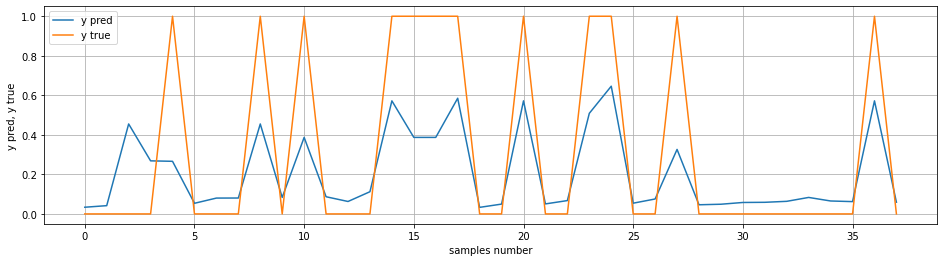

In [22]:
plt.figure(figsize=(16,4))
plt.grid(True)

plt.xlabel('samples number')
plt.ylabel('y pred, y true')

plt.plot(preds[:, 1], label = 'y pred')
plt.plot(y_test.values, label = 'y true')

plt.legend()
plt.show()

### let's establish probability threshold

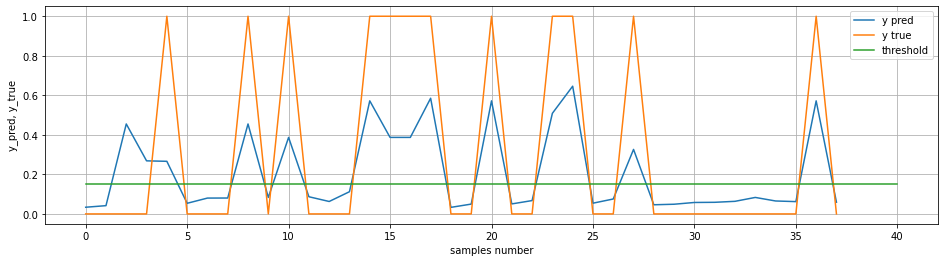

In [23]:
threshold = 0.15 

plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y pred')
plt.plot(y_test.values, label='y true')
# plt.plot(preds[:, 1] > threshold, label='y pred threshold')  # didn't understand what was it about
plt.plot([0, 40], [threshold, threshold], label='threshold')

plt.legend()
plt.show()

## let's find optimal threshold

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

### for this we need 'precision_recall_curve' which computes precision-recall pairs for different probability thresholds

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, preds[:, 1])

In [26]:
len(precision), len(recall), len(thresholds)

(10, 10, 9)

The last precision and recall values are 1. and 0. respectively and do not
have a corresponding threshold. This ensures that the graph starts on the
y axis.

### let's calculate f-scores for different precisions and recalls

In [27]:
f_score = (2 * precision * recall) / (precision + recall)
f_score

array([0.92307692, 0.88      , 0.91666667, 0.86956522, 0.7       ,
       0.66666667, 0.58823529, 0.28571429, 0.15384615, 0.        ])

### let's locate the index of the largest f-score

In [28]:
f_score_max_index = np.argmax(f_score)
f_score_max_index

0

### here's the statistics for the largest threshold

In [29]:
print(f'Best Threshold: {round(thresholds[f_score_max_index], 3)}, \
      \nF-Score: {round(f_score[f_score_max_index], 3)}, \
      \nPrecision: {round(precision[f_score_max_index], 3)}, \
      \nRecall: {round(recall[f_score_max_index], 3)}')

Best Threshold: 0.266,       
F-Score: 0.923,       
Precision: 0.857,       
Recall: 1.0


### let's plot precision/recall dependancy

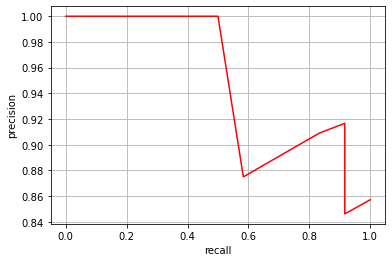

In [30]:
plt.plot(recall, precision, '-r')
plt.grid(True)
plt.ylabel('precision')
plt.xlabel('recall')
plt.show()

### let's print classification_report after applying our best threshold 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.90      0.92      0.91        38
weighted avg       0.92      0.92      0.92        38



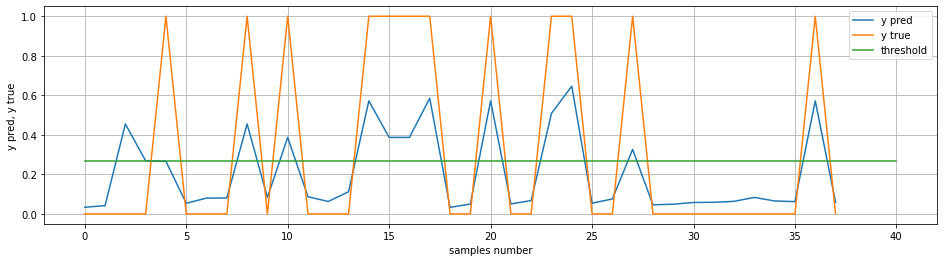

In [31]:
threshold = thresholds[f_score_max_index]
print(classification_report(y_test, preds[:, 1] > threshold))

plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y pred, y true')

plt.plot(preds[:, 1], label='y pred')
plt.plot(y_test.values, label='y true')
plt.plot([0, 40],[threshold, threshold], label='threshold')

plt.legend()
plt.show()

### let's draw confusion matrix for our case

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[24  2]
 [ 1 11]]


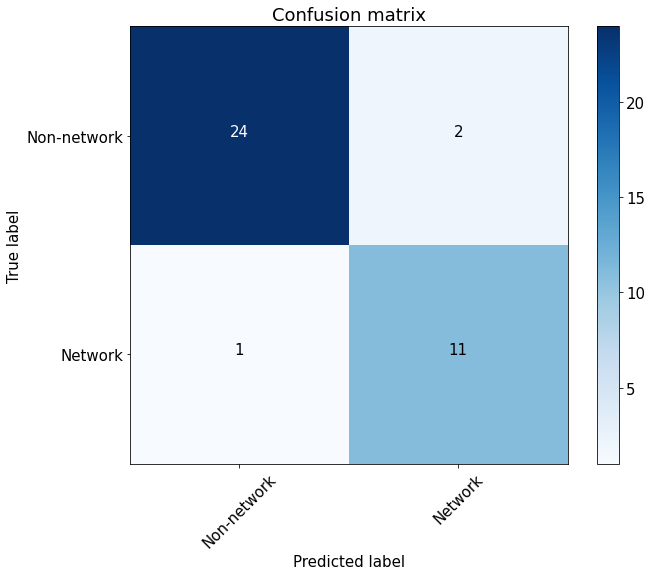

In [34]:
font = {'size': 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds[:, 1] > threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'], title='Confusion matrix')

# plt.savefig("conf_matrix.png")
plt.show()